In [1]:
from os import environ
environ['CUDA_VISIBLE_DEVICES'] = '3'

In [37]:
from __future__ import print_function
import json
from pprint import pprint
import numpy as np

import keras
from functools import reduce
import re
from nltk.tokenize import word_tokenize
from keras import optimizers
from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import Activation,recurrent, Bidirectional, Dense, Flatten, Conv1D, Lambda
from keras.layers import Dropout, LSTM, GRU, concatenate, multiply, add, Reshape, MaxPooling1D, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

In [3]:
def get_dictionary(vocab):
    d = dict()
    with open(vocab) as f:
        lines = f.readlines()
        for l in lines:
            values = l.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            d[word] = coefs
    return d

In [4]:
d = get_dictionary("glove/glove.6B.300d.txt")

In [5]:
with open('train.json') as data_file:    
    data = json.load(data_file)

In [6]:
ids = []
titles = dict()
contexts = dict()
questions = dict()
answers_text = dict()
answers_start = dict()
for i in range(len(data)):
    paragraphs = data[i]["paragraphs"]
    title = data[i]["title"]
    for j in range(len(paragraphs)):
        context = paragraphs[j]["context"]
        qas = paragraphs[j]["qas"]
        for k in range(len(qas)):
            id_ = qas[k]["id"]
            answer = qas[k]["answer"]
            question = qas[k]["question"]
            ids.append(id_)
            titles[id_] = title
            contexts[id_] = context
            answers_start[id_] = answer["answer_start"]
            answers_text[id_] = answer["text"]
            questions[id_] = question


In [7]:
max_para = 650
max_q = 50
dimension = 300
train_len = 500#len(ids)

In [8]:
paras = np.zeros((train_len, max_para, dimension))
qns = np.zeros((train_len, max_q, dimension))

In [9]:
for i in range(train_len):
    if i % 1000 == 0:
        print(i)
    words = word_tokenize(contexts[ids[i]].lower())
    qs = word_tokenize(questions[ids[i]].lower())
    for j in range(min(max_para - 1, len(words))):
        if words[j] in d:
            paras[i][j] = d[words[j]]
    for j in range(min(max_q - 1, len(qs))):
        if qs[j] in d:
            qns[i][j] = d[qs[j]]

0


In [10]:
def create_one_hot_answer(para, answer, answer_start, option, max_length):
    if option == "s":
        from_begin = para[0:answer_start]
    else:
        from_begin = para[0:answer_start+len(answer)]
    l = len(word_tokenize(from_begin))
    one_hot = np.zeros(max_length)
    if option == "s":
        one_hot[min(max_para-1,l)] = 1
    else:
        one_hot[min(max_para-1,l-1)] = 1
    return one_hot
    

In [11]:
ans_starts = [create_one_hot_answer(contexts[ids[i]], answers_text[ids[i]], answers_start[ids[i]], "s", max_para) for i in range(train_len)]

In [12]:
ans_ends = [create_one_hot_answer(contexts[ids[i]], answers_text[ids[i]], answers_start[ids[i]], "e", max_para) for i in range(train_len)]

In [93]:
def Maxout(x, num_unit=16):
    input_shape = x.get_shape().as_list()
   
    ch = input_shape[-1]

    x = K.reshape(x, (-1, input_shape[1], ch // num_unit, num_unit))
    x = K.max(x, axis=3)
    
    return x

def LSTM_D(hidden_unit, input_layer, h_state, c_state, Wi, Wf, Wc, Wo):

    i = concatenate([input_layer, h_state])
    i = Wi(i)
    i = Activation('sigmoid')(i)

    ft = Wf(i)
    ft = Activation('sigmoid')(i)

#     it = Dense(hidden_unit)(i)
#     it = Activation('sigmoid')(i)

    Ct_ = Wc(i)
    Ct_ = Activation('tanh')(i)

    Ct1 = multiply([ft, c_state])
    Ct2 = multiply([i, Ct_])
    Ct = add([Ct1, Ct2])

    ot = Wo(i)

    ht = multiply([ot, Ct])

    return ht, Ct

def HMN(input_layer, r_layer, D1, D2, D3, DD):
    I = layers.concatenate([input_layer, r_layer], axis = 1)
    mt1 = D1(I)
    mt1 = Lambda(Maxout)(mt1)
    mt1 = Dropout(0.5)(mt1)
    mt2 = D2(mt1)
    mt2 = Lambda(Maxout)(mt2)
    mt = layers.concatenate([mt1,mt2])
    mt = D3(mt)
    out = Lambda(Maxout)(mt)
    out = Flatten()(out)
    out = DD(out)
    out = Activation('softmax')(out)
    return out

In [119]:

RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 300
BATCH_SIZE = 128
EPOCHS = 2
hidden_unit = 600
#shared weight layers
shared_LSTM = LSTM(EMBED_HIDDEN_SIZE, return_sequences=True)
shared_start = Dense(max_para, activation='softmax')
shared_end = Dense(max_para, activation='softmax')
Wi = Dense(hidden_unit)
Wf = Dense(hidden_unit)
Wc = Dense(hidden_unit)
Wo = Dense(hidden_unit)
D1a = Dense(640)
D2a = Dense(640)
D3a = Dense(16)
DDa = Dense(max_para)
D1b = Dense(640)
D2b = Dense(640)
D3b = Dense(16)
DDb = Dense(max_para)
Dr = Dense(2*EMBED_HIDDEN_SIZE)
###########################
sentence = layers.Input(shape=(max_para,dimension), dtype='float32')
encoded_sentence =shared_LSTM(sentence)

question = layers.Input(shape=(max_q,dimension), dtype='float32')
encoded_question = shared_LSTM(question)

merge_1 = layers.dot([encoded_sentence, encoded_question], axes = 2 )
A_Q = layers.Activation("softmax")(merge_1)
merge_2 = layers.dot([encoded_question, encoded_sentence], axes = 2 )
A_D = layers.Activation("softmax")(merge_2)
C_Q = layers.dot([A_Q, encoded_sentence], axes = 1 )

C_Q = layers.concatenate([encoded_question, C_Q], axis=2)
C_D = layers.dot([A_D, C_Q], axes=1)
C_ = layers.concatenate([encoded_sentence, C_D], axis=2)

U = Bidirectional(LSTM(EMBED_HIDDEN_SIZE, return_sequences=True))(C_)
U = Dropout(0.5)(U)

h_state_i = layers.Input(shape=(hidden_unit,))
h_state = Dense(hidden_unit, kernel_initializer = keras.initializers.Zeros())(h_state_i)

C_state_i = layers.Input(shape=(hidden_unit,))
C_state = Dense(hidden_unit, kernel_initializer = keras.initializers.Zeros())(C_state_i)

r_layer_init = layers.Input(shape=(3,2*EMBED_HIDDEN_SIZE))
r_layer = Dense(2*EMBED_HIDDEN_SIZE, kernel_initializer = keras.initializers.Zeros())(r_layer_init)
print(r_layer.shape)
start = HMN(U, r_layer, D1a, D2a, D3a, DDa)
end = HMN(U, r_layer, D1b, D2b, D3b, DDb)

#########################
for i in range(5):
    start_comb = Reshape((max_para,1))(start)
    end_comb = Reshape((max_para,1))(end)
    combine_output = concatenate([start_comb,end_comb], axis = 2)
    LSTM_input_U = layers.dot([combine_output, U], axes = 1)
    LSTM_input = Reshape((2*600,))(LSTM_input_U)

    h_state, C_state = LSTM_D(hidden_unit, LSTM_input, h_state, C_state, Wi, Wf, Wc, Wo)
    h_reshape = Reshape((1,600))(h_state)
    r_layer = concatenate([LSTM_input_U, h_reshape], axis = 1)
    r_layer = Dr(r_layer)
    r_layer = Activation('tanh')(r_layer)
    print(r_layer.shape)
    start = HMN(U, r_layer, D1a, D2a, D3a, DDa)
    end = HMN(U, r_layer, D1b, D2b, D3b, DDb)
    

(?, 3, 600)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 3, 600)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 3, 600)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 16)
(?, 653, 1, 16)
(?, 653, 640)
(?, 653, 40, 16)
(?, 653, 640)
(?, 653, 

In [120]:
model = Model([sentence, question, h_state_i, C_state_i, r_layer_init],[start, end])

In [121]:
optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [122]:
ans_s = np.array(ans_starts)
ans_e = np.array(ans_ends)

In [126]:
print('Training')
h =np.zeros((train_len,hidden_unit,))
c = np.zeros((train_len, hidden_unit))
r = np.zeros((train_len,3,2*EMBED_HIDDEN_SIZE))
for i in range(1):
    model.fit([paras, qns, h, c, r], [ans_s, ans_e],
              batch_size=32, epochs=50)
#     model.save('coa_resnet2_new.h5')

Training
Epoch 1/50
500/500 [==============================] - 54s - loss: 12.1278 - activation_266_loss: 6.0298 - activation_267_loss: 6.0980 - activation_266_acc: 0.0260 - activation_267_acc: 0.0060    
Epoch 2/50
500/500 [==============================] - 57s - loss: 9.9224 - activation_266_loss: 4.9384 - activation_267_loss: 4.9840 - activation_266_acc: 0.0240 - activation_267_acc: 0.0160    
Epoch 3/50
500/500 [==============================] - 56s - loss: 9.6719 - activation_266_loss: 4.8206 - activation_267_loss: 4.8514 - activation_266_acc: 0.0380 - activation_267_acc: 0.0280    
Epoch 4/50
500/500 [==============================] - 57s - loss: 9.4850 - activation_266_loss: 4.7415 - activation_267_loss: 4.7435 - activation_266_acc: 0.0340 - activation_267_acc: 0.0260    
Epoch 5/50
500/500 [==============================] - 54s - loss: 9.2986 - activation_266_loss: 4.6527 - activation_267_loss: 4.6459 - activation_266_acc: 0.0360 - activation_267_acc: 0.0200    
Epoch 6/50
500/

500/500 [==============================] - 54s - loss: 0.2068 - activation_266_loss: 0.1054 - activation_267_loss: 0.1014 - activation_266_acc: 0.9660 - activation_267_acc: 0.9660    
Epoch 43/50
500/500 [==============================] - 56s - loss: 0.1340 - activation_266_loss: 0.0589 - activation_267_loss: 0.0752 - activation_266_acc: 0.9800 - activation_267_acc: 0.9800    
Epoch 44/50
500/500 [==============================] - 54s - loss: 0.1175 - activation_266_loss: 0.0591 - activation_267_loss: 0.0584 - activation_266_acc: 0.9800 - activation_267_acc: 0.9740    
Epoch 45/50
500/500 [==============================] - 55s - loss: 0.1385 - activation_266_loss: 0.0739 - activation_267_loss: 0.0646 - activation_266_acc: 0.9800 - activation_267_acc: 0.9800    
Epoch 46/50
500/500 [==============================] - 57s - loss: 0.1798 - activation_266_loss: 0.1367 - activation_267_loss: 0.0431 - activation_266_acc: 0.9680 - activation_267_acc: 0.9880    
Epoch 47/50
500/500 [===========

In [128]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_112 (InputLayer)           (None, 650, 300)      0                                            
____________________________________________________________________________________________________
input_113 (InputLayer)           (None, 50, 300)       0                                            
____________________________________________________________________________________________________
lstm_35 (LSTM)                   multiple              721200                                       
____________________________________________________________________________________________________
dot_104 (Dot)                    (None, 650, 50)       0                                            
___________________________________________________________________________________________

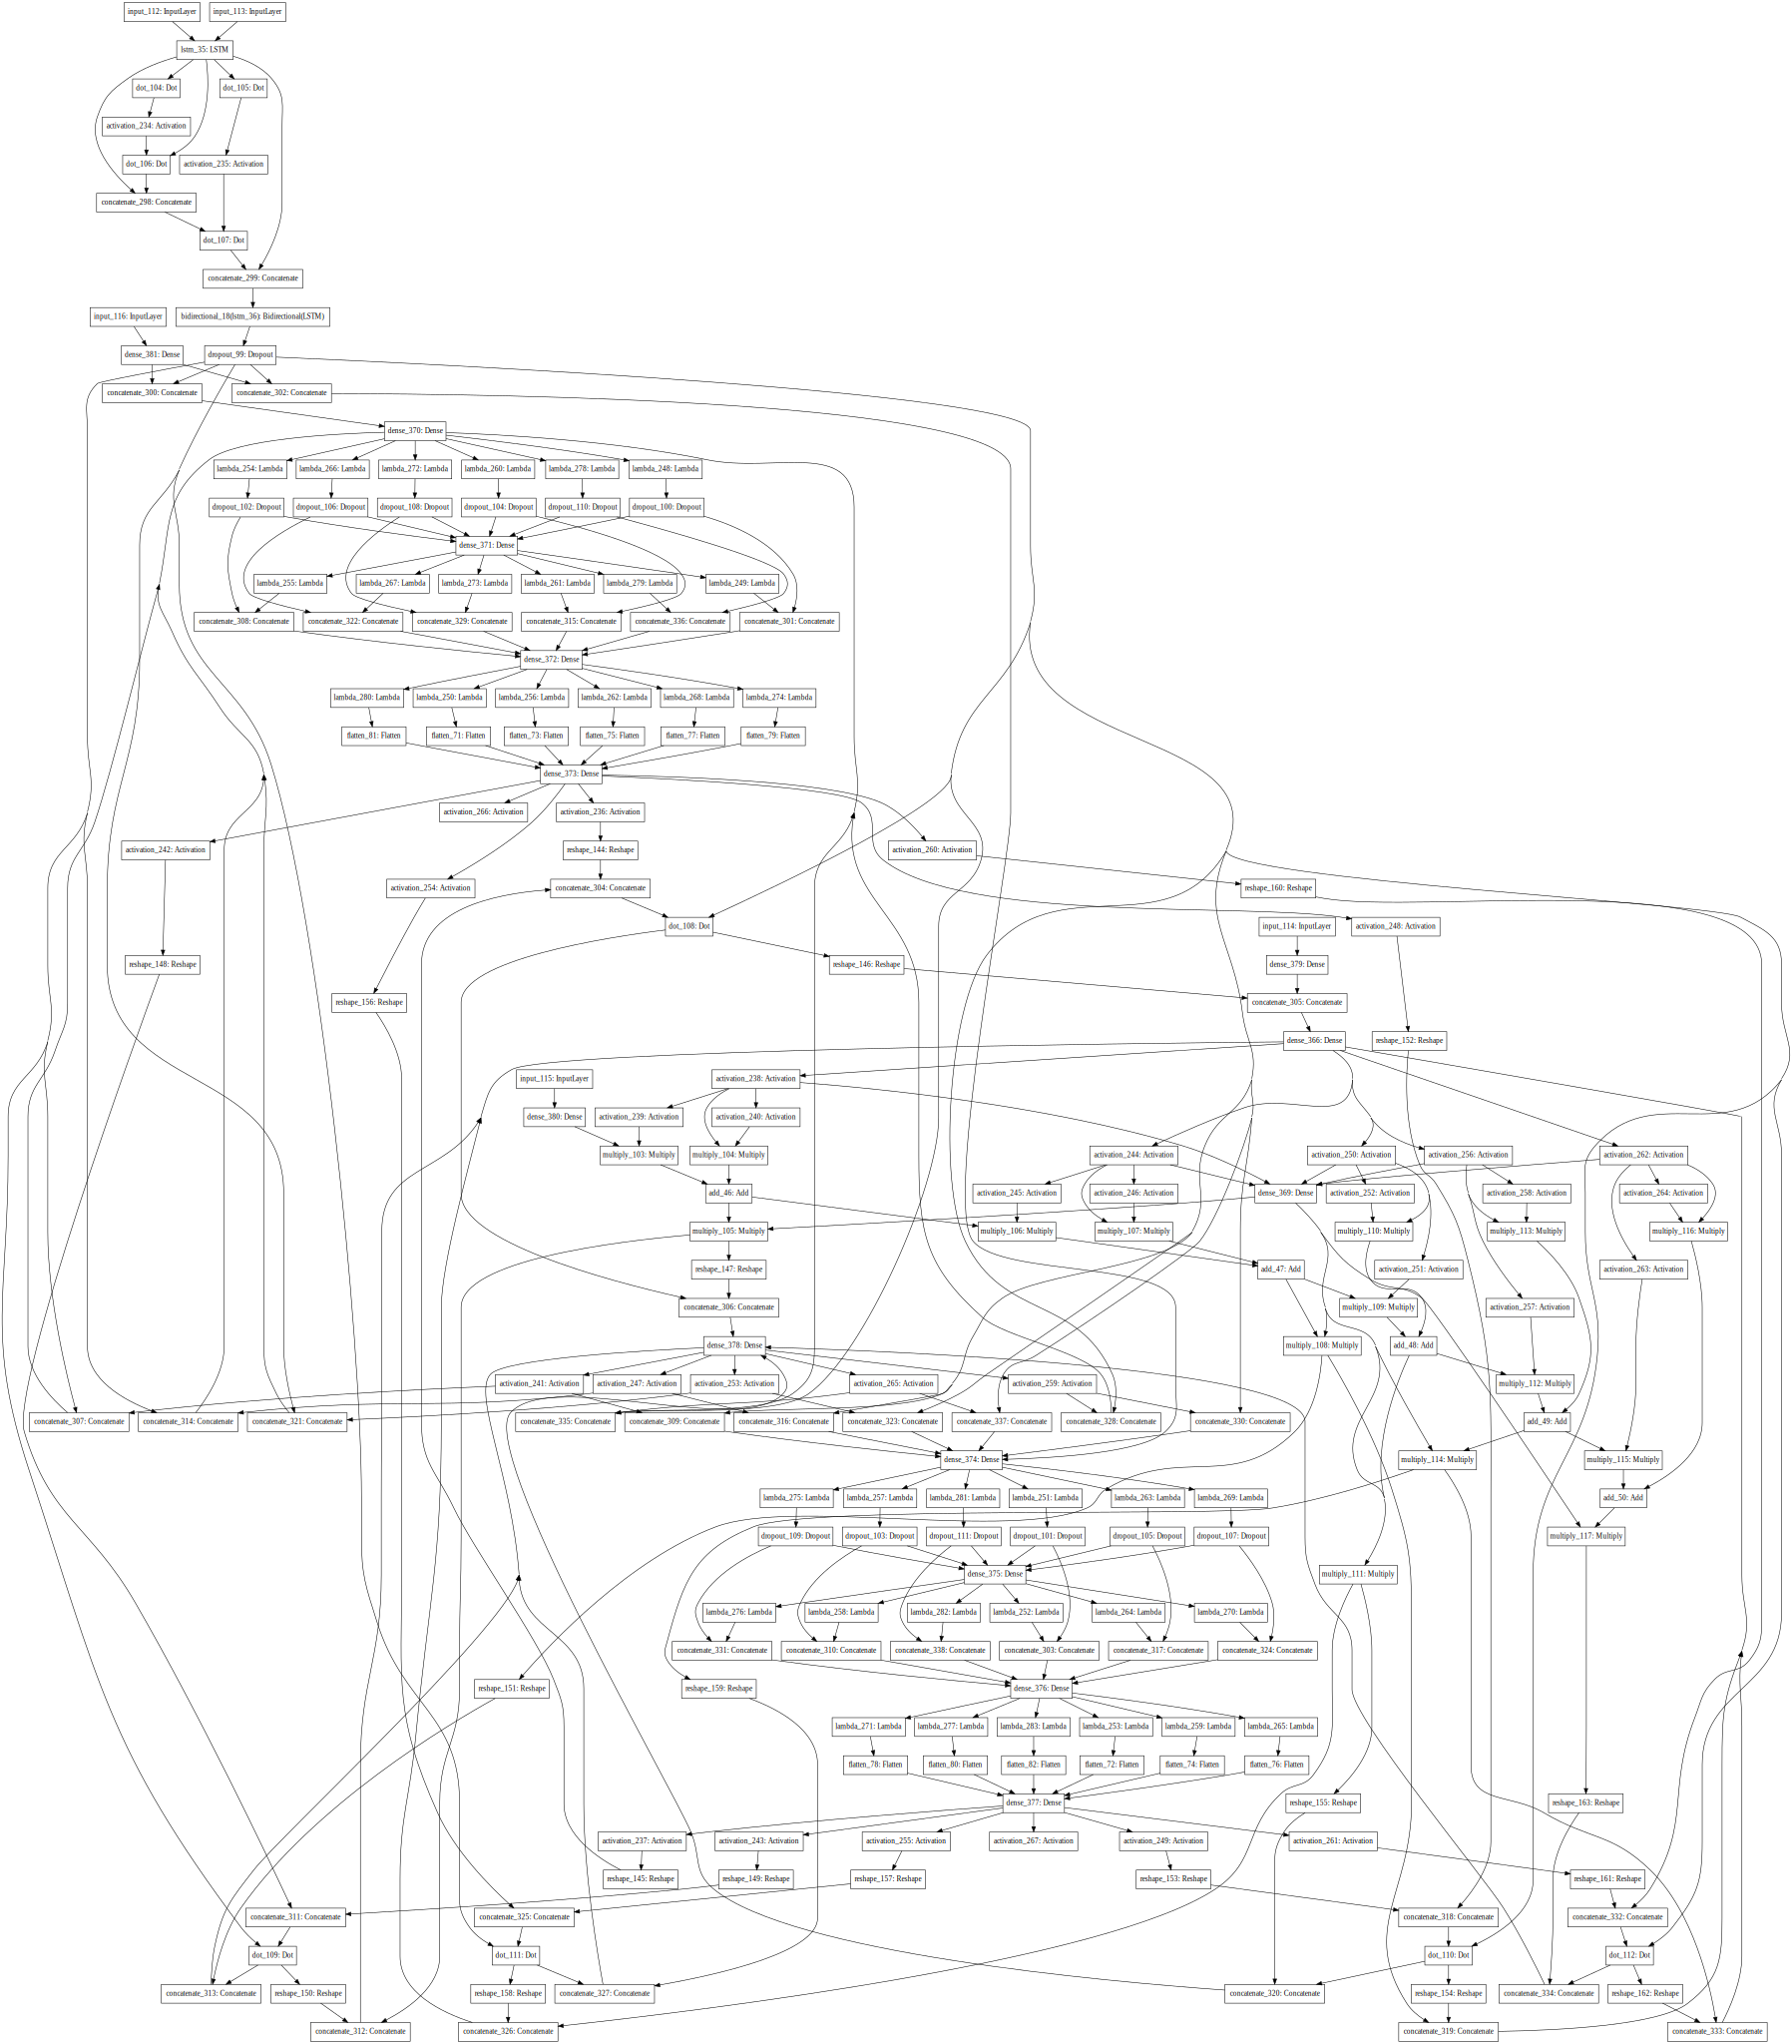

In [127]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [98]:
from keras.utils import plot_model
plot_model(model, to_file='model_3.png')

In [103]:
I = layers.Input((650,600))
mt1 = Dense(600)(I)
mt1 = Lambda(Maxout)(mt1)
mt2 = Dense(600)(mt1)
mt2 = Lambda(Maxout)(mt2)
mt = layers.concatenate([mt1,mt2])
mt = Dense(16)(mt)
out = Lambda(Maxout)(mt)

# print(mt1.shape)
# print(mt2.shape)
# print(t.shape)
# print(out.shape)
a = Model(I, out)

In [104]:
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_96 (InputLayer)        (None, 650, 600)          0         
_________________________________________________________________
dense_307 (Dense)            (None, 650, 600)          360600    
_________________________________________________________________
lambda_137 (Lambda)          (None, 650, 37)           0         
_________________________________________________________________
dense_308 (Dense)            (None, 650, 600)          22800     
_________________________________________________________________
lambda_138 (Lambda)          (None, 650, 37)           0         
_________________________________________________________________
concatenate_174 (Concatenate (None, 650, 74)           0         
_________________________________________________________________
dense_309 (Dense)            (None, 650, 16)           1200      
__________

In [112]:
def Maxout(x, num_unit=16):

    input_shape = x.get_shape().as_list()
   
    ch = input_shape[-1]

    
    print(x.shape)
    x = K.reshape(x, (-1, input_shape[1], ch // num_unit, num_unit))
    print(x.shape)
    x = K.max(x, axis=3)
       

    return x

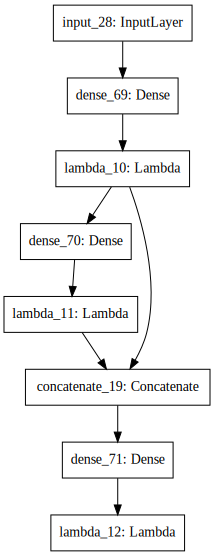

In [58]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(a).create(prog='dot', format='svg'))